### Power Rabi experiment to calibrate X180

First, get a backend.

In [1]:
from qiskit import IBMQ

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
backend = IBMQ.providers()[1].backends(open_pulse=True, name="ibmq_montreal")[0]

In [3]:
cals = backend.defaults().instruction_schedule_map
cals.get("x", [0]).instructions

((0,
  Play(Drag(duration=160, amp=(0.1832358400791979+0j), sigma=40, beta=-0.595935658285224, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

Next, set up the Rabi experiment parameters:

In [4]:
import numpy as np

qubit = 0

duration = 128
sigma = 40
num_points = 128

drive_amps = np.linspace(0, 1, num_points)

Create the circuit template:

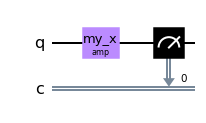

In [5]:
from qiskit import circuit


amp_param = circuit.Parameter("amp")

rabi_circuit = circuit.QuantumCircuit(1, 1)
rabi_circuit.append(circuit.Gate("my_x", 1, [amp_param]), [0])
rabi_circuit.measure(0, 0)
rabi_circuit.draw("mpl")

Create the calibration template:

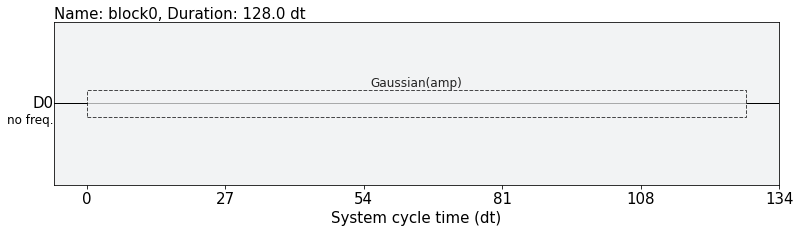

In [6]:
from qiskit import pulse


with pulse.build(backend) as x_calibration:
    pulse.play(pulse.Gaussian(duration, amp_param, sigma),
               pulse.drive_channel(qubit))

x_calibration.draw()

Register the pulse calibration with the circuit:

In [7]:
rabi_circuit.add_calibration("my_x", [0], x_calibration, [amp_param])

Finally, bind the values we want to test:

In [8]:
rabi_experiment = []
for amp in drive_amps:
    circ = rabi_circuit.copy().assign_parameters({amp_param: amp})
    rabi_experiment.append(circ)

rabi_experiment[-1].calibrations

{'my_x': {((0,),
   (1.0,)): ScheduleBlock(Play(Gaussian(duration=128, amp=(1+0j), sigma=40), DriveChannel(0)), name="block0", transform=AlignLeft())}}

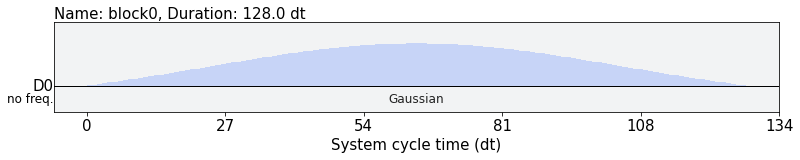

In [9]:
rabi_experiment[-1].calibrations["my_x"][((0,), (1.0,))].draw()

Execute!

In [10]:
from qiskit import execute

num_shots = 2048
job = backend.run(rabi_experiment, shots=num_shots)

In [11]:
collect_new = False
if collect_new:
    result = job.result()
    response = []
    for i in range(len(drive_amps)):
        response.append(result.get_counts(i)["1"] / num_shots)
    # Save data
    np.savetxt('power_rabi_demo_11-18.csv', response, delimiter=',')

response = np.genfromtxt('power_rabi_demo_11-18.csv', delimiter=',', dtype=complex)

In [12]:
import warnings
warnings.filterwarnings("ignore")

Plot result and fit result for the optimal pi pulse amplitude!

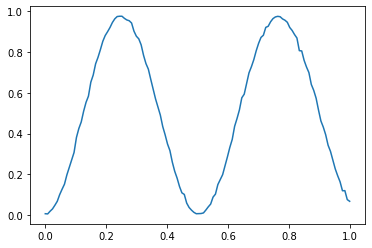

In [13]:
import matplotlib.pyplot as plt

plt.plot(drive_amps, response)

Pi pulse amplitude 0.2592595064810324


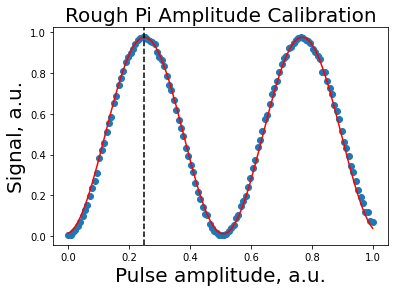

In [14]:
from scipy.optimize import curve_fit

def cos_fit_func(x, A, B, t, phi):
    return B + A * np.cos(2*np.pi*x / t + phi)
fitparams, conv = curve_fit(cos_fit_func, drive_amps, response, [-1, 0.5, 0.5, 0])

first_peak = abs(np.pi - fitparams[3]) * fitparams[2] / (2*np.pi)
pi_amp = abs(fitparams[2]/2)

plt.scatter(drive_amps, response)
plt.plot(drive_amps, cos_fit_func(drive_amps, *fitparams), color='red')
plt.axvline(first_peak, color='black', linestyle='dashed')
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)
print('Pi pulse amplitude {amp}'.format(amp=pi_amp))

In [15]:
pi_pulse = pulse.library.Gaussian(duration, pi_amp, sigma)

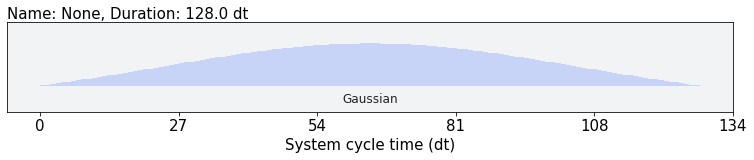

In [16]:
pi_pulse.draw()

Further exercise -- the `Drag` pulse is actually a better choice than `Gaussian`! Why?